# Heart Disease

<h2 style="color:#45A29E">1. Inleiding</h2>

Hart- en vaatziektes is een verzamennaam voor verschillende ziekten aan het het of aan de bloedvaten. Hart en vaatziektes zijn de belangrijkste doodsoorzaak in Nederland. Dertig procent van alle mensen sterft eraan. 

Ze zijn onder te verdelen in een aantal soorten:
- slechte bloedaanleg
- hartfalen
- hartritmestoornissen
- aangeboren hartziektes
- aandoenlingen aan de hartkleppen

Wat hart- en vaatziekten veroorzaakt verschilt per ziekte. Wel zijn er een aantal factoren die ervoor zorgen dat u meer kans heeft om last te krijgen van hart- en vaatziekten, namelijk: roken, overgewicht, diabetes, hoge bloeddruk en een te hoog cholesterolgehalte.

Dataset:

- age
- sex
- chest pain type (4 values)
- resting blood pressure
- serum cholestoral in mg/dl
- fasting blood sugar > 120 mg/dl
- resting electrocardiographic results (values 0,1,2)
- maximum heart rate achieved
- exercise induced angina
- oldpeak = ST depression induced by exercise relative to rest
- the slope of the peak exercise ST segment

<h2 style="color:orange">2. Dataset</h2>

### 2.1 Import libraries

In [205]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from time import time

import warnings
warnings.filterwarnings("ignore")

### 2.2 Data veroveren

In [206]:
data = pd.read_csv('heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


<h2 style="color:orange">3. Dataset</h2>

**Wat is het probleem?**

<em>Het probleem is om te voorspellen of iemand een hartziekte heeft of niet op basis van een aantal features.</em>

<br>

**Wat voor labels heb je?**

<em>We hebben een label genaamd 'HeartDisease'. Dit is een binary label. 0 geeft aan dat de patient geen hartziekte heeft en bij 1 heeft een patient wel een  hartziekte</em>

<br>

**Dimensie dataset**


In [58]:
data.shape

(918, 12)

**Soorten data/features**

In [59]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

<p style="color:#F64C72">Insights</p>

- <em>Er zijn 918 rijen en 12 kolommen in de dataset</em>
- <em>Er zijn 5 kolommen die geen getallen zijn. Dit zijn: Sex, ChestpainType, RestingECG, ExerciseAngina en ST_Slope. Deze moeten worden veranderd naar getallen<em>

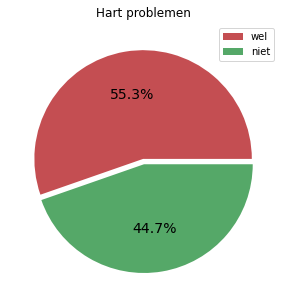

In [60]:
with_disease = data[data['HeartDisease'] == 1]['HeartDisease'].count()
without_disease = data[data['HeartDisease'] == 0]['HeartDisease'].count()

colors = sns.color_palette('deep')[3 : 1 : -1]

# Bekijk of labels wel verdeeld zijn. Niet dat 90% van de data wel borstkanker heeft en maar 10% niet o.i.d. Je kunt dus zien dat het 
# 40/60 verdeeld is. Dat is nog prima.
plt.figure(figsize=(5,5))
plt.pie([with_disease, without_disease], colors=colors, autopct='%.1F%%', textprops = {'fontsize':14}, explode = [0,0.05])
plt.legend(labels=['wel','niet'])
plt.title('Hart problemen')
plt.show()

<p style="color:#F64C72">Insights</p>

<em>55% van de kandidaten heeft hartproblemen en 45% niet. De dataset is dus redelijk in balans.<em>

In [61]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


<p style="color:#F64C72">Insights</p>

- De meeste patienten zijn tussen de 47 en 60 jaar oud.
- Bij RestingBP is de minimale waarde 0, terwijl 25% van de goep bijvoorbeeld 120 bevat. De gemiddelde is 132. Dit kan dus een uitsmijter zijn. Dezelfde geldt voor de cholesterol-gehalte.
- FastingBS kan wel gewoon minimaal 0 zijn, aanegzien de meeste ook gewoon 0 als waarde hebben.
- Zo'n 55% van de patienten heeft hartproblemen.
- De standaardafwijking van cholelesterol-gehalte is redelijk hoog. er moet dus wel een variatie zijn.

<h2 style="color:orange">4. Voorspelling</h2>

**Welke classifier zal het beste zijn en waarom?**

<em>Ik verwacht dat Random Forest Classifier het beste classifer voor dit probleem zal zijn. RFC staat bekend om zijn hoge accuraatheid. Ook is er hier sprake van een binaire tabel en een kleine dataset, dus Logistic Regression zou hier het ook goed doen.

<em>Wel is dat RF meer accuraat gericht is en Logistic Regression juist tijdgericht. Daarom kan RF het wel beter doen dan Logistic Regression. Toch zal RF wel slomer zijn.<em>

<br>

**Welke hyperparameters zijn relevant en waarom?**

- <em>n_estimators: aantal trees: zegt genoeg.max_depth: De diepte van een DT kan zeker uitmaken op de uitkomst (meerdere if statements om zo nauwkeurig mogelijk te zijn).
- min_samples_leaf: Het aantal nodes in een DT kan veel invloed hebben op de efficiëntie. Meer nodes = meer splitsingen, wat meer rekenkracht kost. Toch is dit een relatief kleine dataset.
- max_depth: spreekt voor zich</em>

<br>

<h2 style="color:orange">5. Methoden</h2>

**Welke preprocessing stappen zijn nodig?**

- <em>Checken of er duplicates en/of lege cellen zijn </em>
- <em>Categorisch omzetten naar numeriek</em>
- <em>Bekijken of er outliers zijn. Zoja, outliers eruit halen</em>
- <em>Feature importance<em>
- <em>Data normaliseren<em>

<br>

**Welke classifiers ga je vergelijken?**

- <em>Logistic Regression</em>
- <em>K-Nearest Neighbors<em>
- <em>Random Forest Regression (ensamble)<em>
- <em>VotingClassifier (ensamble)<em>

<br>

**Welke performace metric is passend?**

<em>F1 Score<em>
- <em>We willen vermijden dat er een patient wordt voorspeld als 'geen hartziekte', terwijl die dat juist wel heeft, oftewel de positieve correct classificieren (recall)<em>
- <em>We willen dat de model zovaak mogelijk correct classificeerd (precision).

<h4 style="color:lightblue">5.1 Checken of er duplicates en/of lege cellen zijn</h4>

Bekijk naar lege cellen

In [62]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Bekijk of er duplicates zijn

In [63]:
data.duplicated().sum()

0

<p style="color:#F64C72">Insights</p>

- Er zijn geen gedupliceerde waarden
- Er zijn geen lege cellen

<h4 style="color:lightblue">5.2 Categorisch omzetten naar numeriek</h4>

In [207]:
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 0, 'N': 1})

In [208]:
columns_to_encode = ['ChestPainType','RestingECG','ST_Slope']
orginal_chestPainType = data['ChestPainType'] # Nodig voor ANOVA test

data = pd.get_dummies(columns=columns_to_encode, data=data)

data['ChestPainType'] = orginal_chestPainType

data.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType
0,40,0,140,289,0,172,1,0.0,0,0,1,0,0,0,1,0,0,0,1,ATA
1,49,1,160,180,0,156,1,1.0,1,0,0,1,0,0,1,0,0,1,0,NAP
2,37,0,130,283,0,98,1,0.0,0,0,1,0,0,0,0,1,0,0,1,ATA
3,48,1,138,214,0,108,0,1.5,1,1,0,0,0,0,1,0,0,1,0,ASY
4,54,0,150,195,0,122,1,0.0,0,0,0,1,0,0,1,0,0,0,1,NAP


<h4 style="color:lightblue">5.3 Bekijken of er outliers zijn. Zoja, outliers eruit halen</h4>

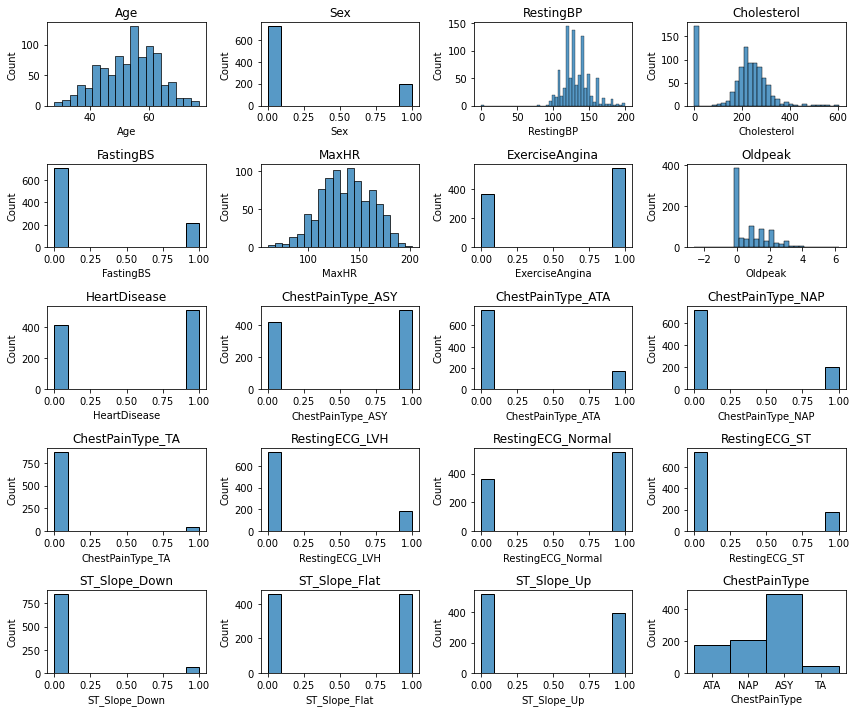

In [66]:
plt.figure(figsize=(12,10))
for idx, column in enumerate(data.columns):
    plt.subplot(5, 4, idx+1)
    sns.histplot(x=column, data=data)
    plt.title(column)
    plt.tight_layout()
plt.show()

<p style="color:#F64C72">Insights</p>

- Waardes zoals Age en MaxHR zien er redelijk normaal verdeeld uit.
- Bij cholesterol zijn er heelveel 0 waardes. Dit zijn hoogstwaarschijnlijk uitsmijters, want 0 als waarde voor cholesterol is niet mogelijk.
- Er zijn veel meer mannen met hartproblemen dan vrouwen.
- OldPleak heeft een negatieve waarde. Deze kunnen niet negatief zijn.
- Er zijn zowat even veel ST_Slope_Flat bij zowel heartdiseased als niet.
- ST_Slope_Down en ChestPainType_TA zijn heel wat hoger bij degenen zonder hertziektes.

<br><br>

Om er zeker van te zijn dat er uitsmijters zijn, worden er hieronder boxplots getekend.

In [67]:
non_binary_columns = [col for col in data if not np.isin(data[col].unique(), [0, 1]).all()]

non_binary_columns.remove('ChestPainType') # Bevat 0,1,2,3 -> geen binary, wordt wel meegenomen door code

non_binary_columns

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

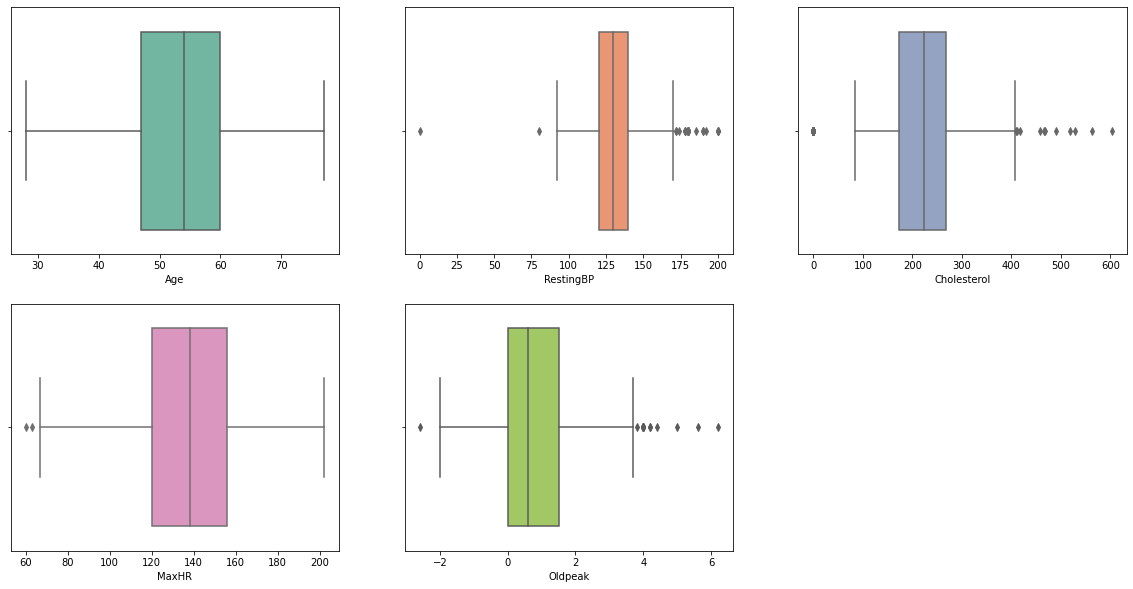

In [68]:
fig, axes = plt.subplots(2, 3)
# sns.set(style="darkgrid")
for i, ax in zip(range(len(non_binary_columns)), axes.flat):
    color = sns.color_palette("Set2")[i]
    sns.boxplot(data[non_binary_columns[i]], orient='h', ax=ax, color=color)
    plt.title(non_binary_columns[i])


fig.delaxes(axes[1][2])
fig.set_size_inches(20, 10)
plt.show()

<p style="color:#F64C72">Insights</p>

- Age heeft geen uitsmijters
- RestingBP heeft één 0-waarde. Bovendien bevat het ook meerdere outliers
- Cholesterol heeft veel 0-waardes en alles boven de 450 is onzin.
- Oldpeak heeft ook wat outliers

In [209]:
def detect_outliers(data_1):
    outliers=[]
    threshold=3 # Boven de 3 standaarddeviaties is het een outlier
    mean = np.mean(data_1)
    std =np.std(data_1)
    
    for value in data_1:
        z_score = (value - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(value)
    return outliers

In [210]:
for col in data.select_dtypes(include=np.number):
    if col in non_binary_columns:
        column = data[col]
        print(f"{col}:", detect_outliers(column))

Age: []
RestingBP: [190, 200, 200, 200, 0, 190, 200, 192]
Cholesterol: [529, 603, 564]
MaxHR: [60]
Oldpeak: [5.0, -2.6, 4.2, 5.6, 4.2, 6.2, 4.4]


Cholesterol

In [211]:
mean_cholesterol = data[data['Cholesterol'] > 0]['Cholesterol'].mean()
data['Cholesterol'] = data['Cholesterol'].apply(lambda x: x if x > 0 else mean_cholesterol)

df_cholesterol_outliers = data[data['Cholesterol'] >= 529]
data.drop(df_cholesterol_outliers.index, axis=0, inplace=True)

data.shape

(915, 20)

RestingBP

In [212]:
data = data[(data['RestingBP'] > 0) & (data['RestingBP'] < 190)]

data.shape

(907, 20)

MaxHR

In [213]:
df_maxhr_outliers = data[data['MaxHR'] == 60]
data.drop(df_maxhr_outliers.index, axis=0, inplace=True)

data.shape

(906, 20)

Oldpeak

In [214]:
data = data[(data['Oldpeak'] > -2.6) & (data['Oldpeak'] < 4.2)]

data.shape

(899, 20)

<h4 style="color:lightblue">5.4 Feature Selection</h4>

##### 5.4.1 Heatmap


Eerst even de Heartdisease kolom achteraan verplaatsen, zodat we een beter inzicht krijgen

In [77]:
old_columns = data.columns.to_list()

hd_index = old_columns.index('HeartDisease')

hd = old_columns.pop(hd_index)

new_columns = [*old_columns, hd]

data = data[new_columns]

<AxesSubplot:>

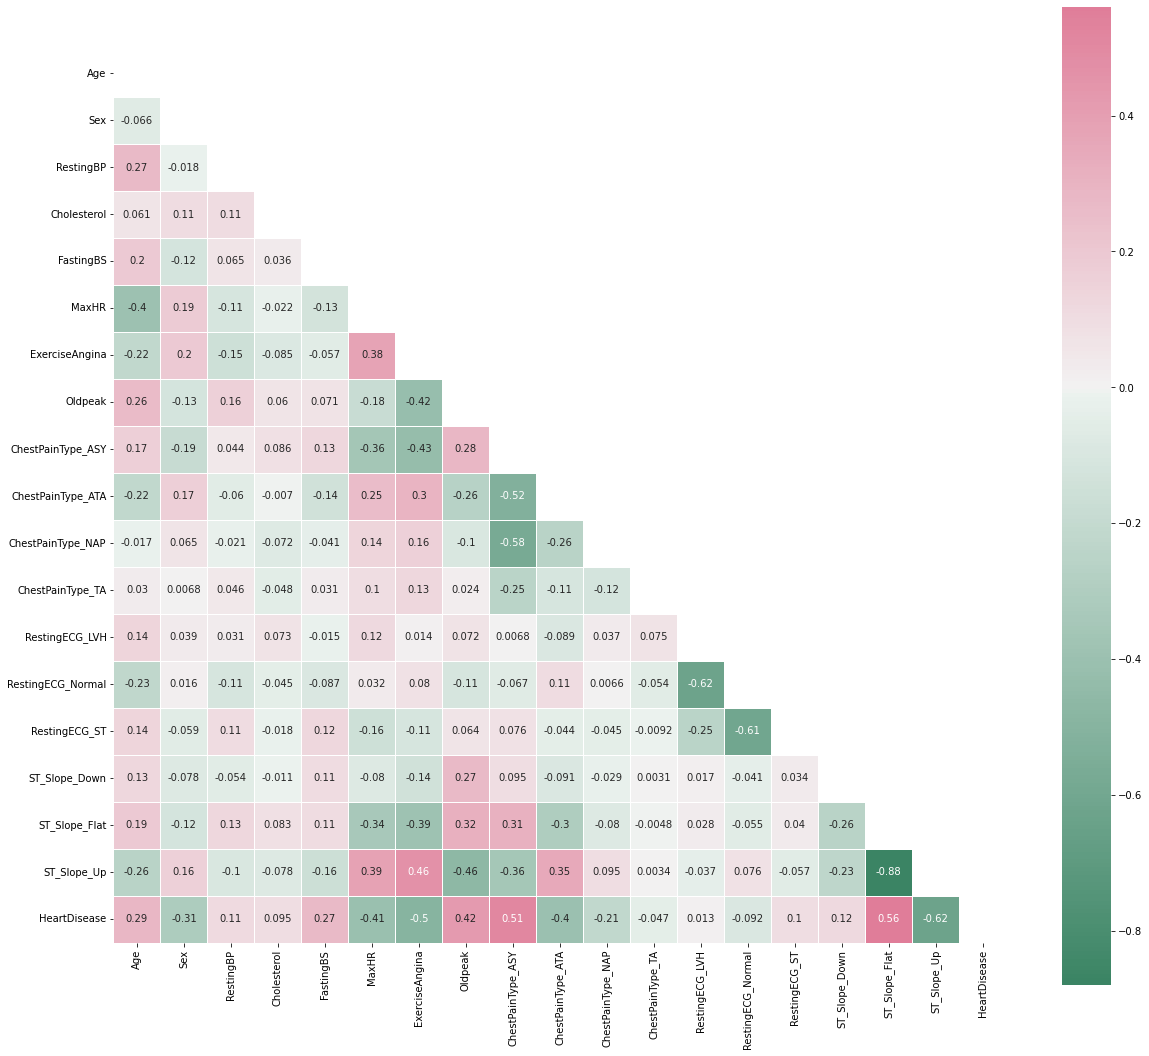

In [78]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(150, 1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

<p style="color:#F64C72">Insights</p>

- Op eerste blik lijkt het dat MaxHR, ST_Slope_Flat en ExerciseAngina een sterk correlatie te hebben met Heartdisease.
- Kolommen zoals Cholesterol hebben volgens de heatmap weinig invloed op de label. Ook hebben deze indirect niet veel invloed op andere features

#### 5.4.2 Statistics

- interval -> t-test
- nominaal -> chi square
- nominaal + rangorde -> chi square of mann whitney

##### T-test

Bekijk eerst even of kolommen normaal verdeeld zijn

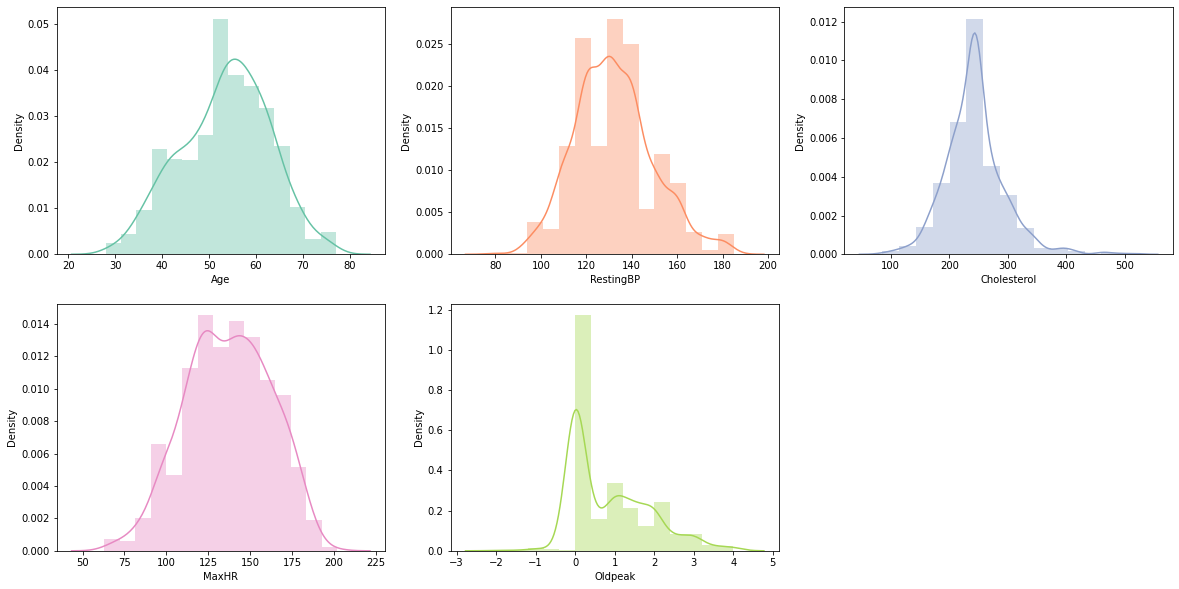

In [22]:
fig, axes = plt.subplots(2,3, figsize=(20,10))

for i, ax in zip(range(len(non_binary_columns)), axes.flat):
    color = sns.color_palette("Set2")[i]
    sns.distplot(data[non_binary_columns[i]], bins=15, ax=ax, color=color)
    plt.title(non_binary_columns[i])

fig.delaxes(axes[1][2])
plt.show()


<p style="color:#F64C72">Insights</p>

- MaxHR en RestingBP zien er nog redelijk normaal verdeeld uit
- Age ook wel, maar wel verschuift naar rechts
- Cholesterol en oldpeak niet

##### Kolmogorov-Smirnov

We moeten eerst bekijken of we een normale t-test of een welsch t-test moeten doen. Dit kunnen we beslissen door zeker te weten of de dataset normaal verdeeld is. Als dat zo is, kunnen we de normale t-test gebruiken. Zoniet, dan de welsch t-test.

Om te bepalen of de dataset normaal verdeeld is, kunnen we de kolomogoriv-smirlov test doen. 

H0: De verdeling is normaal verdeeld.

In [79]:
from scipy.stats import kstest, ttest_ind
from scipy.stats import ttest_ind

In [80]:
# Kolomogorov-Smirlov test om te zien of een kolom (data) normaal is verdeeld.
alpha = 0.05
for col in non_binary_columns:
    try:
        stat, p = kstest(data[col], 'norm')

        if p > alpha:
            print(f'{col}: Normaal verdeeld (Behoud H0) \n--> stat: {stat} \n--> p waarde: {p}\n')
        else:
            print(f'{col}: Niet normaal verdeeld (Verwerp H0) \n--> stat: {stat} \n--> p waarde: {p}\n')
    except:
        pass


Age: Niet normaal verdeeld (Verwerp H0) 
--> stat: 1.0 
--> p waarde: 0.0

RestingBP: Niet normaal verdeeld (Verwerp H0) 
--> stat: 1.0 
--> p waarde: 0.0

Cholesterol: Niet normaal verdeeld (Verwerp H0) 
--> stat: 1.0 
--> p waarde: 0.0

MaxHR: Niet normaal verdeeld (Verwerp H0) 
--> stat: 1.0 
--> p waarde: 0.0

Oldpeak: Niet normaal verdeeld (Verwerp H0) 
--> stat: 0.4866518353726363 
--> p waarde: 1.1371081512467288e-196



Eigenlijk moeten we telkens eerst de assumpties van een t test controleren. Gegeven de steekproefomvang maken we ons geen zorgen over de (normaal) verdeling. Belangrijk is dat er sprake is van vergelijkbare variantie in beide groepen. Dat wordt gecheckt met Levene's test.

In [81]:
wel = data[data['HeartDisease'] == 1]
geen = data[data['HeartDisease'] == 0]

In [82]:
from scipy.stats import levene

print(f"Cholesterol: {levene(wel['Cholesterol'], geen['Cholesterol'], center='mean')[1]}")
print(f"Age: {levene(wel['Age'], geen['Age'], center='mean')[1]}")
print(f"RestingBP: {levene(wel['RestingBP'], geen['RestingBP'], center='mean')[1]}")
print(f"FastingBS: {levene(wel['FastingBS'], geen['FastingBS'], center='mean')[1]}")
print(f"MaxHR: {levene(wel['MaxHR'], geen['MaxHR'], center='mean')[1]}")
print(f"Oldpeak: {levene(wel['Oldpeak'], geen['Oldpeak'], center='mean')[1]}")

Cholesterol: 0.002634913630555437
Age: 0.03507241487767327
RestingBP: 0.005024275759043811
FastingBS: 5.360060353285369e-67
MaxHR: 0.7545016640169941
Oldpeak: 2.3894026189998983e-22


<p style="color:yellow">Conclusie</p>

- Alleen de variantie van MaxHR wel en MaxHR geen is het vergelijkbaar. Toch is het niet normaal verdeeld, dus alles moet een welsch test worden.

Dus: Gebruik Welsch t-test.

<br>
<em>De t-test van scipy geeft niet heel veel informatie. We missen informatie over de effect size. Pearson R kan ons hierbij helpen. Daarom gebruiken we researchpy. Dit geeft al wat meer inzicht<em>

#### Interval kolommen 

In [83]:
import researchpy as rp
from scipy.stats import ttest_ind

In [84]:
alpha = 0.05
pearson_treshold = 0.2

def show_welsch_test_results(column_name):
    try:
        _, res = rp.ttest(group1=wel[column_name], group2=geen[column_name], equal_variances=False)
        pvalue = res['results'][3]
        pearsons_r = res['results'][9]

        print(f"p-value: {pvalue}")

        if pvalue > alpha:
            print(f'{column_name}: Geen significant verschil (Behoud H0) --> verwijder kolom')
        else:
            print(f'{column_name}: Wel significant verschil (Verwerp H0)')
            if pearsons_r > pearson_treshold:
                print(f'Pearsons r: {pearsons_r} (sterk genoeg)')
            else: 
                print(f'Pearsons r: {pearsons_r} (te zwak) --> verwijder kolom')
    except Exception as e:
        print(e)
        print("Something went wrong. Have you given the correct parameters?")

In [85]:
show_welsch_test_results('Cholesterol')

p-value: 0.0044
Cholesterol: Wel significant verschil (Verwerp H0)
Pearsons r: 0.0977 (te zwak) --> verwijder kolom


In [86]:
show_welsch_test_results('Age')

p-value: 0.0
Age: Wel significant verschil (Verwerp H0)
Pearsons r: 0.2933 (sterk genoeg)


In [87]:
show_welsch_test_results('RestingBP')

p-value: 0.0008
RestingBP: Wel significant verschil (Verwerp H0)
Pearsons r: 0.1116 (te zwak) --> verwijder kolom


In [88]:
show_welsch_test_results('FastingBS')

p-value: 0.0
FastingBS: Wel significant verschil (Verwerp H0)
Pearsons r: 0.2831 (sterk genoeg)


In [89]:
show_welsch_test_results('MaxHR')

p-value: 0.0
MaxHR: Wel significant verschil (Verwerp H0)
Pearsons r: 0.412 (sterk genoeg)


In [90]:
show_welsch_test_results('Oldpeak')

p-value: 0.0
Oldpeak: Wel significant verschil (Verwerp H0)
Pearsons r: 0.4456 (sterk genoeg)


<p style="color:yellow">Conclusie</p>


- Cholesterol enn RestingBP weggooien

#### Chi-square

In [91]:
alpha = 0.05
chi_square_treshold = 0.2

def show_chi_square_results(column_name):
    try:
        _, result = rp.crosstab(data['HeartDisease'], data[column_name], test= "chi-square")
        p_value = result['results'][1]
        cramers_phi = result['results'][2]

        print(f"p-value: {p_value}")

        if p_value > alpha:
            print('Geen significant verschil (Behoud H0) --> verwijder kolom')
        else:
            print('Wel significant verschil (Verwerp H0)')
            if cramers_phi > chi_square_treshold:
                print(f'Cramers_phi: {cramers_phi} (sterk genoeg)')
            else: 
                print(f'Cramers_phi: {cramers_phi} (te zwak) --> verwijder kolom')
        
    except:
        print("Something went wrong. Have you given the correct parameter?")


In [92]:
show_chi_square_results('Sex')

p-value: 0.0
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.3095 (sterk genoeg)


In [93]:
show_chi_square_results('ExerciseAngina')

p-value: 0.0
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.498 (sterk genoeg)


In [94]:
show_chi_square_results('ChestPainType_ASY')

p-value: 0.0
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.5139 (sterk genoeg)


In [95]:
show_chi_square_results('ChestPainType_ATA')

p-value: 0.0
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.4019 (sterk genoeg)


In [96]:
show_chi_square_results('ChestPainType_TA')

p-value: 0.1551
Geen significant verschil (Behoud H0) --> verwijder kolom


In [97]:
show_chi_square_results('ChestPainType_NAP')

p-value: 0.0
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.212 (sterk genoeg)


In [98]:
show_chi_square_results('RestingECG_LVH')

p-value: 0.6895
Geen significant verschil (Behoud H0) --> verwijder kolom


In [99]:
show_chi_square_results('RestingECG_Normal')

p-value: 0.0057
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.0922 (te zwak) --> verwijder kolom


In [100]:
show_chi_square_results('RestingECG_ST')

p-value: 0.0026
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.1005 (te zwak) --> verwijder kolom


In [101]:
show_chi_square_results('ST_Slope_Down')

p-value: 0.0004
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.1174 (te zwak) --> verwijder kolom


In [102]:
show_chi_square_results('ST_Slope_Flat')

p-value: 0.0
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.5599 (sterk genoeg)


In [103]:
show_chi_square_results('ST_Slope_Up')

p-value: 0.0
Wel significant verschil (Verwerp H0)
Cramers_phi: 0.6221 (sterk genoeg)


<p style="color:#F64C72">Insights</p>

- ChestPainType_TA, RestingECG_LVH, RestingECG_Normal, RestingECG_ST, ST_Slope_Down verwijderen

#### Anova

Stel nu dat we een target variable hebben met drie of meer categorieen, bijvoorbeeld we willen voorspellen welke chestpaintype iemand heeft. We willen weten of leeftijd van belang is om te voorspellen welke chestpain type een patient heeft. Een correlatie is mogelijk, maar is afhankelijk welke klasse welk cijfer krijgt. Bij klasse kun je nog een rangorde voorstellen, maar stel voor dat je religie van de respondent wil voorspellen, dan is een correlatie een rare maat. De oplossing: ANOVA

Voorbeeld normale anova

In [104]:
import statsmodels.formula.api as sfa
import statsmodels.api as sa

model = sfa.ols("Age ~ C(ChestPainType)", data= data).fit()
sa.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(ChestPainType),3.0,4229.468247,1409.822749,16.587834,1.702891e-10
Residual,895.0,76067.274801,84.991368,NaN,NaN


Om te weten of we de normale anova of de welsch anova moeten gebruiken, moeten we weten of het normaal verdeeld is en ook testen of de variances van de types gelijk zijn. Als ze gelijk zijn, kunnen we de normale gebruiken. Zoniet, dan moeten we de welsch versie gebruiken. Dit kunnen we bijvoorbeeld doen met een bertlett test.

Of het normaal verdeeld is of niet, weten wel al. Nu de variances assumptie:

In [431]:
from scipy.stats import bartlett

bartlett(data['ChestPainType_ASY'], data['ChestPainType_ATA'],data['ChestPainType_TA'], data['ChestPainType_NAP'] )

BartlettResult(statistic=561.9859516601509, pvalue=1.7533744257363136e-121)

In [432]:
from scipy.stats import levene

levene(data['Age'][data['ChestPainType_ASY']],
               data['Age'][data['ChestPainType_ATA']],
               data['Age'][data['ChestPainType_TA']],
               data['Age'][data['ChestPainType_NAP']])

LeveneResult(statistic=169.42288300380292, pvalue=1.0007430603232303e-102)

De barlett value is lager dan 5%. Dat betekent dat we de null hypothese kunnen verwerpen. Dus, niet alle groepen hebben dezelfde variances. 

Testen of het wel klopt. Inderdaad, de varianties verschillen.

In [433]:
print(data['ChestPainType_ASY'].std())
print(data['ChestPainType_ATA'].std())
print(data['ChestPainType_TA'].std())
print(data['ChestPainType_NAP'].std())

0.4988870336004242
0.3926862825849269
0.21818112563826397
0.4161362713522491


Conclusie: doorgaan met welsch ANOVA. Deze is robuust voor de verschillen in variantie en daar hoeven we dan niet naar te kijken

In [105]:
from pingouin import welch_anova

welch_anova(dv='Age', between='ChestPainType', data=data)

,Source,ddof1,ddof2,F,p-unc,np2
0,ChestPainType,3,173.600351,16.634336,1.518747e-09,0.052673


De p-value (p-unc) is kleiner dan 5%. Dit betekent dat we de null-hypotheses kunnen verwerpen. Er is dus een significant verschil tussen de age en de verschillende chestpaintypes.

Nu willen we weten welke group het verschil geeft. Dit kunnen we doen met een tukeys post hoc test.

In [435]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(data['Age'], data['ChestPainType'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
ASY,ATA,-5.7272,0.0,-7.8387,-3.6157,True
ASY,NAP,-1.8071,0.0918,-3.8023,0.1882,False
ASY,TA,-0.2687,0.9977,-3.9671,3.4296,False
ATA,NAP,3.9201,0.0003,1.4487,6.3916,True
ATA,TA,5.4585,0.0024,1.4829,9.434,True
NAP,TA,1.5383,0.7428,-2.3767,5.4534,False


Significant verschil tussen de gemiddeldes van de groepen:
- ASY en ATA
- ATA en NAP
- ATA en TA

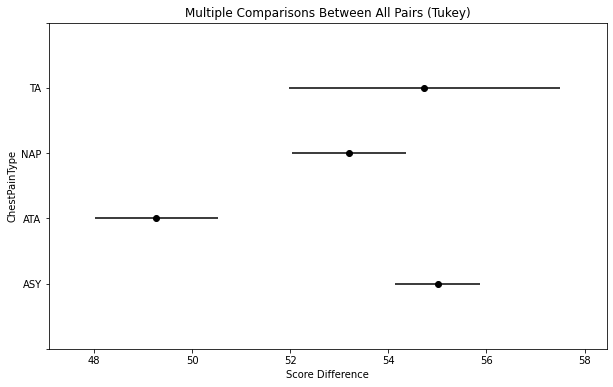

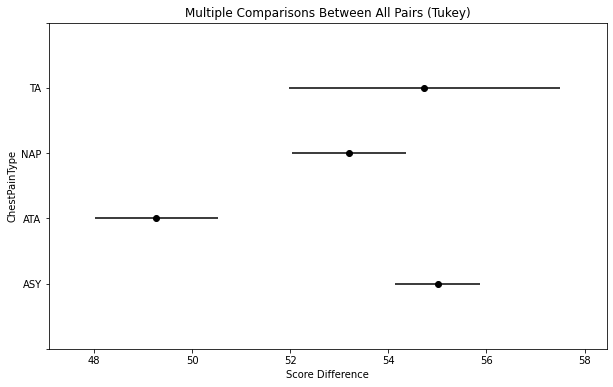

In [436]:
#De verschillen kunnen ook geplot worden
post_hoc_res.plot_simultaneous(ylabel= "ChestPainType", xlabel= "Score Difference")

#### PCA

In [215]:
data.drop(columns=['ChestPainType'], axis=1, inplace=True)

In [223]:
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)

In [224]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [225]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
 
pca = PCA()
 
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)
 
pca.explained_variance_ratio_

array([2.22705674e-01, 1.07738586e-01, 8.19736691e-02, 7.78954643e-02,
       7.70734861e-02, 6.17723595e-02, 5.82049198e-02, 5.56938895e-02,
       5.10200182e-02, 4.80450265e-02, 4.13123942e-02, 3.80200365e-02,
       3.15174978e-02, 2.76160745e-02, 1.94109035e-02, 3.27752914e-32,
       1.01755771e-32, 3.24781412e-33])

In [229]:
#Covariance Matrix
cov_mat = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' %eig_vals)
print('Eigenvectors \n%s' %eig_vecs)


Eigenvalues 
[ 2.53312360e+03  6.66066810e+02  2.87108819e+02  6.80716875e+01
  1.09230770e+00  3.62455775e-01  3.34690329e-01  2.81077939e-01
  5.95711803e-02  7.49954509e-02  1.28718440e-01  1.47412789e-01
  1.67802520e-01  1.91492208e-01  1.99322808e-01  1.55504289e-16
 -2.78082617e-16  6.32750775e-17]
Eigenvectors 
[[ 1.32489494e-02  1.69727828e-01  1.30773437e-01  9.76230986e-01
  -2.39268962e-02  2.52726661e-03 -1.43854910e-02  4.36852774e-03
   9.74662545e-04 -1.93534926e-03 -3.13191050e-03 -2.12007560e-03
  -6.57851713e-03 -4.58134294e-03 -3.54548310e-04 -2.64446948e-17
  -4.09814903e-19  4.61193445e-17]
 [ 8.48958752e-04 -3.02478826e-03  2.87119387e-04  6.96793653e-04
  -6.10906975e-02  1.00074508e-01  1.99488240e-02 -1.13976733e-01
  -2.97344283e-02  2.34713034e-02  4.48755758e-01  7.82814225e-01
  -7.10754753e-02 -3.15446442e-01 -2.29523136e-01  3.17807635e-15
  -3.46976405e-15 -7.89673127e-15]
 [ 4.09492614e-02  1.41665542e-01  9.76636668e-01 -1.56164876e-01
  -5.82729862e

In [226]:
# Fitting Logistic Regression To the training set
from sklearn.linear_model import LogisticRegression 
 
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the test set result using
# predict function under LogisticRegression
y_pred = classifier.predict(X_test)

f1_score(y_test, y_pred)

0.8924302788844621

|                          	| accuracy 	|
|--------------------------	|-------------	|
| None                    	| 0.892      	| 
| 1                         	| 0.8916       	| 
| 2 	| 0.896       	|
| 3 	| 0.90        	|     
| 4 	| 0.890        	| 
| 7 	| 0.8837        	| 

<p style="color:#F64C72">Insights</p>

- n_components 3 geeft beste resultaat

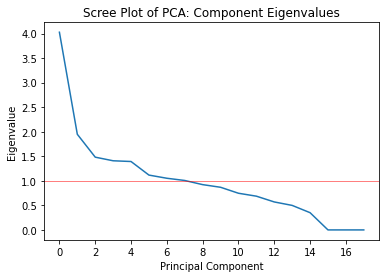

In [227]:
def scree_plot():
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Scree Plot of PCA: Component Eigenvalues')
    show()

scree_plot()

<p style="color:#F64C72">Insights</p>

- De eerste component heeft de grootste eigenvalue (hoe verspreid de data is). Daarom is deze de principal component.

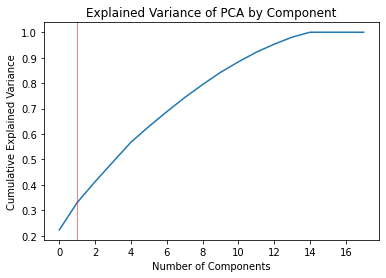

In [228]:
def var_explained():
    import numpy as np
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axvline(x=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Explained Variance of PCA by Component')
    show()

var_explained()

<p style="color:#F64C72">Insights</p>

- De cumulatieve waarde gaat geleidelijk en daalt daarna na een aantal components.

verwijder onnodige kolommen

In [142]:
data.drop(['Cholesterol', 'RestingBP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ChestPainType', 'ST_Slope_Down'], axis=1, inplace=True)

<h2 style="color:orange">6. Train classifiers</h2>

split data in train en test

In [302]:
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, stratify=y)

In [303]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.fit_transform(X_test)

In [304]:
import scipy.stats as stats

zscores = stats.zscore(X_train)

print(zscores[0])

[ 0.37756431 -0.52814523  1.79234483 -1.45689601 -1.19716874 -0.86804755
  0.91734947 -0.47247274 -0.53503228  1.         -0.87959321]


In [305]:
has_higher_than_3 = False

for i in zscores:
    if all(y <= 3 for y in i) is False:
        has_higher_than_3 = True


has_higher_than_3

True

<p style="color:#F64C72">Insights</p>

- Er zijn zscores die groter zijn dan 3. De drie betekent dat meer dan 99% van de waardes binnen 3 standaarddeviaties valt van het gemiddelde. Als het boven de 3 is, zou dit ongebruikelijk zijn, wat betekent dat er misschien outliers zouden zijn.

### 6.1 Classifiers

Met behulp van een aantal ML classifiers wordt er bepaald of iemand een hartziekte kan hebben of niet. Er worden verschillende modellen getrained: 
- Logistic regression
- K-neirest Neighbor
- Random Forest Tree. 
- VotingClassifier

#### 6.1.1 Logistic Regression
We gebruiken Gridsearch om de Logistic Regressor te optimaliseren. Door brute force worden de beste parameters ervoor gevonden.

In [339]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid_values = {'C': [0.01, 0.1,1,10,100], 'solver': ['lbfgs', 'liblinear', 'sag','newton-cg']}

glr = GridSearchCV(LogisticRegression(random_state=42), grid_values, cv=10, scoring='f1')

glr.fit(X_train, y_train)

glr.best_params_

{'C': 0.01, 'solver': 'lbfgs'}

In [342]:
start = time()
lr = LogisticRegression(random_state=42, C=0.01)

lr.fit(X_train, y_train)

end = time()

lr_train_time = end - start

pred = lr.predict(X_test)

f1_score(y_test, pred)

0.8924302788844621

#### 6.1.2 RandomForestClassifier

Ik heb geprobeerd om de GridSearchCV te gebruiken bij de RFC, maar dit duurde enorm lang. Daarom leek het handig om eerst een Randomized Search te doen. M.b.v. de RandomizedSearchCV krijg ik een heldere beeld over de paramters.

In [308]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import random

# Number of trees in random forest
n_estimators = [random.randint(1, 200) for _ in range (1, 50)]
#Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [*[i for i in range(1, 20)], 30,40,50,70,90,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rrfc = RandomizedSearchCV(RandomForestClassifier(random_state=11), random_grid, cv=7, n_jobs=-1, scoring='f1')

rrfc.fit(X_train, y_train)

rrfc.best_estimator_

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=4,
                       min_samples_split=4, n_estimators=188, random_state=11)

Nu doen we een Gridsearch met heel wat minder parameters, aangezien we ongeveer al weten wat ongeveer de beste parameters zijn.

In [155]:
# Number of trees in random forest
n_estimators = [i for i in range(164,168)]
# Maximum number of levels in tree
max_depth = [i for i in range(3,6)]
# Minimum number of samples required to be a leaf node
# min_sample_split = [2,3,4]
min_sample_leaf = [3,4,5]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_leaf': min_sample_leaf,
                # 'min_samples_split': min_sample_split,
                'max_features': ['log2']}

grfc = GridSearchCV(RandomForestClassifier(random_state=11), random_grid, cv=7, scoring='f1')

grfc.fit(X_train, y_train)

grfc.best_estimator_
    

RandomForestClassifier(max_depth=4, max_features='log2', min_samples_leaf=3,
                       n_estimators=164, random_state=11)

In [316]:
start = time()

# rfc = RandomForestClassifier(max_depth=4, min_samples_leaf=3, max_features='sqrt',
#                        n_estimators=161, random_state=11)

rfc = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=4,
                       min_samples_split=4, n_estimators=188, random_state=11)
rfc.fit(X_train, y_train)

end = time()

rf_train_time = end - start

pred = rfc.predict(X_test)

f1_score(y_test, pred)

0.8914728682170544

##### 6.1.3 K-Neighbors

In [310]:
from sklearn.neighbors import KNeighborsClassifier

start = time()

knn = KNeighborsClassifier(n_neighbors=9) # Brute forced
knn.fit(X_train, y_train)

end = time()

knn_time = end - start

pred = knn.predict(X_test)

f1_score(y_test, pred)


0.8677685950413223

In [293]:
cross_val_score(lr, X_train, y_train, cv=7).mean()

0.8400777786842892

#### 6.1.4 Stacking

In [311]:
from sklearn.ensemble import StackingClassifier

estimators = [('rf', RandomForestClassifier(max_depth=15, min_samples_leaf=3,n_estimators=124, random_state=11)), ('knn', KNeighborsClassifier())]

sc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=0.1, solver='liblinear'))

start = time()

sc.fit(X_train, y_train)

end = time()

sc_time = end - start

pred = sc.predict(X_test)

f1_score(y_test, pred)

0.8818897637795274

#### 6.1.5 GradientBoosting

In [312]:
from sklearn.ensemble import GradientBoostingClassifier

gc = GradientBoostingClassifier(n_estimators=10, learning_rate=1, max_depth=10, random_state=11)

start = time()

gc.fit(X_train, y_train)

end = time()

gc_time = end - start

pred = gc.predict(X_test)
f1_score(y_test, pred)

0.8429752066115702

<h2 style="color:orange">7. Resultaten</h2>

In [343]:
from sklearn.metrics import confusion_matrix

def get_scores(model):
    pred = model.predict(X_train)
    f1_train = f1_score(y_train, pred)
    pred = model.predict(X_test)
    f1_test = f1_score(y_test, pred)
        
    print(confusion_matrix(y_test, pred))
    print('-----------')

    return {'train': f1_train, 'test': f1_test}
    

In [344]:
lr_scores = get_scores(lr)
knn_scores = get_scores(knn)
rfc_scores = get_scores(rfc)
sc_scores = get_scores(sc)
gc_scores = get_scores(gc)


[[ 86  16]
 [ 11 112]]
-----------
[[ 88  14]
 [ 18 105]]
-----------
[[ 82  20]
 [  8 115]]
-----------
[[ 83  19]
 [ 11 112]]
-----------
[[ 85  17]
 [ 21 102]]
-----------


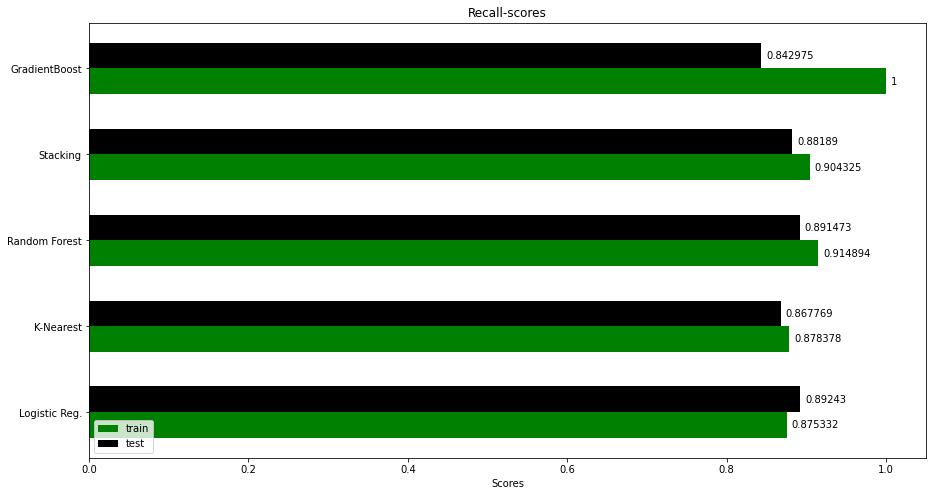

In [345]:
import numpy as np

train = [lr_scores['train'], knn_scores['train'], rfc_scores['train'], sc_scores['train'], gc_scores['train']]
test = [lr_scores['test'], knn_scores['test'], rfc_scores['test'], sc_scores['test'], gc_scores['test']]

models = ('Logistic Reg.', 'K-Nearest', 'Random Forest', 'Stacking', 'GradientBoost')

x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(15,8))
train_bars = ax.barh(x - width/2, train, width, label='train', color='g')
test_bars = ax.barh(x + width/2, test, width, label='test', color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scores')
ax.set_title('Recall-scores')
ax.set_yticks(x, models)
ax.legend(loc="lower left")

ax.bar_label(train_bars, padding=5)
ax.bar_label(test_bars, padding=5)

plt.show()

<p style="color:yellow">Insights</p>

- RFC: ziet er goed uit. Niet echt sprake van underfitting of overfitting.
- Stacking classifier is ook niet verkeerd. Als ik wist hoe je die goed zou kunnen tunen, dan zou het misschien beter werken. 
- KNN: sprake van underfitting
- LR: test is beter dan train??
- GradientBoost: duidelijk sprake van overfitting

##### 7.1 ROC-curve

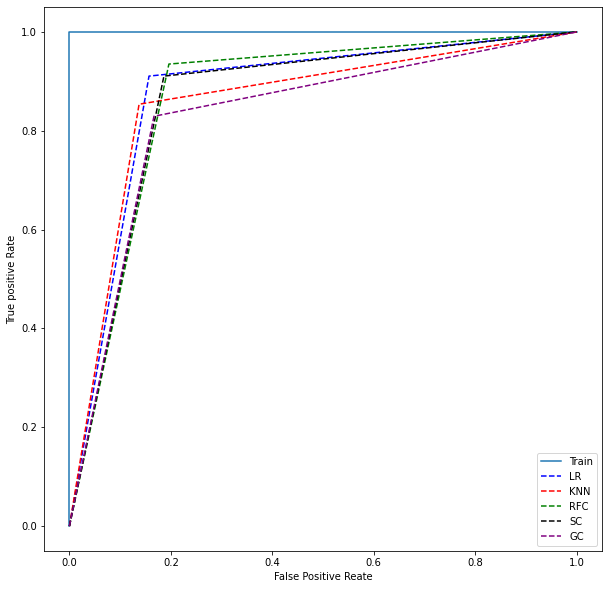

In [346]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_pred = lr.predict(X_test)
knn_pred = knn.predict(X_test)
rfc_pred = rfc.predict(X_test)
sc_pred = sc.predict(X_test)
gc_pred = gc.predict(X_test)


auc = roc_auc_score(y_test, lr_pred)

train_fpr, train_tpr, _ = roc_curve(y_test, y_test)

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_pred)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_pred)
sc_fpr, sc_tpr, _ = roc_curve(y_test, sc_pred)
gc_fpr, gc_tpr, _ = roc_curve(y_test, gc_pred)

plt.figure(figsize=(10, 10))
plt.plot(train_fpr, train_tpr)
plt.plot(lr_fpr, lr_tpr, 'b--')
plt.plot(knn_fpr, knn_tpr, linestyle='--', color='red')
plt.plot(rfc_fpr, rfc_tpr, linestyle='--', color='green')
plt.plot(sc_fpr, sc_tpr, linestyle='--', color='black')
plt.plot(gc_fpr, gc_tpr, linestyle='--', color='purple')
plt.legend(['Train', 'LR', 'KNN', 'RFC', 'SC', 'GC'])
plt.xlabel('False Positive Reate')
plt.ylabel('True positive Rate')

plt.show()

<p style="color:yellow">Insights</p>

- Random Forst Classifier komt het dichtst bij de train rate. Wat je wilt hebben is dat je test lijn zo links boven mogelijk is. De oppervlakte onder de lijn moet zo groot mogelijk zijn. De RFC doet daat het best in. Dit zegt dus dat deze het minste False Positive heeft met hoogste True Positive Rate.

##### 7.2 Parameters

Eerst had ik zelf met random parameters de modellen getest. De Recall-score bleef rond 0.82-0.86 zweven. Voor iedere model veranderde ik bijvoorbeeld de n_estimations, of max_depth etc. Uiteindelijk bedacht ik me dat we hier heel goed GridSearch kunnen toepassen. We kunnen zo heel snel de optimale parameters vinden.

Met behulp van RandomSearch en Gridsearch is er geprobeerd om de optimale parameters te vinden voor elke model. Met Random Forest Classifier heb ik een RandomSearch gedaan, aangezien het met GridSearch alleen te lang duurde. Maar de naam zegt het al, het is random. Hoogstwaarschijnlijk heb ik ook niet de optimale parameters ervoor gevonden.

|                          | F1 zonder parameters | F1 met 'optimale' parameters| 
|--------------------------|--------|----------------------------|
| Logistic Regression      | 0.876  | 0.877                      |
| Random Forest Classifier | 0.878  | 0.900                      | 
| K-nearest Neighbor       | 0.865  | 0.889                      |
| Stacking                 | -      | 0.895                      |
| GradientBoosting         | -      | 0.848                      |

##### 7.4 Gebruik alle featuers

Bij het gebruik van alle features, verschilt het niet echt veel met het gebruik van belangrijkste features. Toch heb ik alleen maar de features boven de 0.2 correlatie meegenomen. Misschein zou het verschillen als ik minder features meenam. 

##### 7.5 Tijd

In [347]:
print(f"LR train tijd: {lr_train_time}")
print(f"KNN train tijd: {knn_time}")
print(f"RFC train tijd: {rf_train_time}")
print(f"SC train tijd: {sc_time}")
print(f"GC train tijd: {gc_time}")

LR train tijd: 0.002479076385498047
KNN train tijd: 0.0008130073547363281
RFC train tijd: 0.10833930969238281
SC train tijd: 0.4461231231689453
GC train tijd: 0.028471708297729492


<p style="color:yellow">Insights</p>

- Stacking is het traagst (ensamble)
- KNN is het snelst (niet echt learning)

<h2 style="color:orange">8. Conclusie</h2>

De beste classifier komt volgens dit onderzoek op Random Forest Classifier. Zelf zat ik te twijfelen over Random Forest Classifier en Logistic Regression. Ik wist wel dat RFC hier goed bij zou passen, alleen had ik ook het voermoede dat Logistic Regression misschien beter zou werken. Ik weet zeker dat ik de optimale parameters niet heb meegegeven (heb het wel zo goed mogelijk geprobeerd). Met betere parameters verwacht ik zelfs dat RFC het nog beter zou kunnen doen. Dat geldt trouwens ook voor stacking en GC.

Random Forest Classifier heeft wel de minste False Positives tegenover de True Positives. Dit geeft aan dat deze model bij dit probleem minder fouten maakt.

Door een aantal kolommen uit de dataset te gooien, is de F1 score van de meeste classifiers ietjes verhoogd. De andere twee zijn zowat dezelfde gebleven. Is het het waard om de kolommen te verwijderen? meh. Je ziet niet echt veel verschil. Toch telt elke procent. Misschien had ik wat meer features eruit moeten gooien. Ik heb nu de correlaties boven 0.2 gepakt.

Qua tijd is KNN het snelst. Hier ben ik wel verbaast over, aangezien LR juist sneller hoort te zijn. Toch denk ik dat dit gewoon te maken heeft met het feit data de dataset klein is. Bij grotere datasets denk ik wel dat LR sneller zal zijn. Dat SC het traagst is, is wel duidelijk. Het bestaat uit verschillende classifiers.

**Hoe kan je het verbeteren?**

- Uitschieters eruit halen. Er zijn sowieso nog uitschieters.
- cross_validation toepassen. 
- train_test_split testen op verschillende test_sizes.
- Gridseach met verschillende cv values uitvoeren.
- Last but not least, de RFC moeten we vaker runnen. Het is totaal gerandomized. Zo kwam een max_depth uit op 5, maar misschien zou een ander beter zijn geweest, die niet in de search voorbij kwam.

Ook heb ik een aantal paramters niet gebruikt. Misschien zouden die parameters wel van belang kunnen zijn met een combinatie van andere parameters. Zo heb ik bijvoorbeeld bij Logistic Regression de solver 'saga' niet gebruikt. Samen met een penalty van 'l2', kwam de recall op 100%. Dat is mooi! Maar waarom heb ik die er dan niet bijgezet? Nou, de accuracy van de model werd maar 50%... De true positives werd altijd 0! Hé! Daar hebben we helemaal niks aan! Zo zijn er wat aantal paramters die de accuracy heel erg omlaag halen, terwijl de recall score juist goed is. Daarom heb ik deze er express uitgehaald. 

Al met al, ik heb mooie resultaten bereikt met deze modellen. Een F1-score van 90% is niet niets.

<h2 style="color:orange">9. Bronnen</h2>

- https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
- https://researchpy.readthedocs.io/en/latest/ttest_documentation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
- https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/
- https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832#:~:text=StandardScaler%20removes%20the%20mean%20and,standard%20deviation%20of%20each%20feature.
- https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python
- https://stackoverflow.com/questions/20229822/check-if-all-values-in-list-are-greater-than-a-certain-number
- https://datagy.io/python-z-score/